In [15]:
!pip install -Uq upgini catboost

In [16]:
import io
import zipfile
import requests
import pandas as pd
from os.path import exists

df_path = "/content/train.csv"
df = pd.read_csv(df_path)
df.head()
df = df.sample(n=12_000, random_state=0)
df["store"] = df["store"].astype(str)
df["item"] = df["item"].astype(str)

df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()



,date,store,item,sales
0,2013-01-01,2,3,19
1,2013-01-01,7,5,5
2,2013-01-01,10,21,33
3,2013-01-01,3,27,11
4,2013-01-01,4,9,19


In [26]:
train = df[df["date"] < "2017-01-01"]
test = df[df["date"] >= "2017-01-01"]

In [18]:
train_features =  train.drop(columns=["sales"])
train_target = train["sales"]
test_features = test.drop(columns=["sales"])
test_target = test["sales"]

In [ ]:
from upgini import FeaturesEnricher, SearchKey
from upgini.metadata import CVType

enricher = FeaturesEnricher(
    search_keys= {
        "date": SearchKey.DATE,
    },
    cv = CVType.time_series
)
enricher.fit(train_features,
            train_target,
            eval_set=[(test_features, test_target)])

In [ ]:
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

model = CatBoostRegressor(verbose=False, allow_writing_files=False, random_state=0)

enricher.calculate_metrics(
    train_features, train_target,
    eval_set=[(test_features, test_target)],
    estimator = model,
    scoring = "mean_absolute_percentage_error"
)

In [ ]:
import pandas as pd

batch_size = 1000
batches = [df[i:i+batch_size] for i in range(0, len(df), batch_size)]
enriched_data = []

for batch in batches:
    enriched_batch = enricher.transform(batch, keep_input=True)
    enriched_data.append(enriched_batch)

enriched_df = pd.concat(enriched_data, ignore_index=True)
enriched_df.sort_values("date", inplace=True)
enriched_df.reset_index(drop=True, inplace=True)
print(enriched_df.head())


# SMAPE before Enrichment :

In [23]:
model.fit(train_features, train_target)
preds = model.predict(test_features)
eval_metric(test_target.values, preds, "SMAPE")

[40.984044429997745]

# SMAPE after Enrichment :

In [31]:
enriched_train = enriched_df[enriched_df["date"] < "2017-01-01"]
enriched_test = enriched_df[enriched_df["date"] >= "2017-01-01"]

enriched_train_features = enriched_train.drop(columns=["sales"])
enriched_train_target = enriched_train["sales"]
enriched_test_features = enriched_test.drop(columns=["sales"])
test_target = enriched_test["sales"]

model.fit(enriched_train_features, enriched_train_target)
enriched_preds = model.predict(enriched_test_features)
eval_metric(test_target.values, enriched_preds, "SMAPE")


[17.290721110483627]

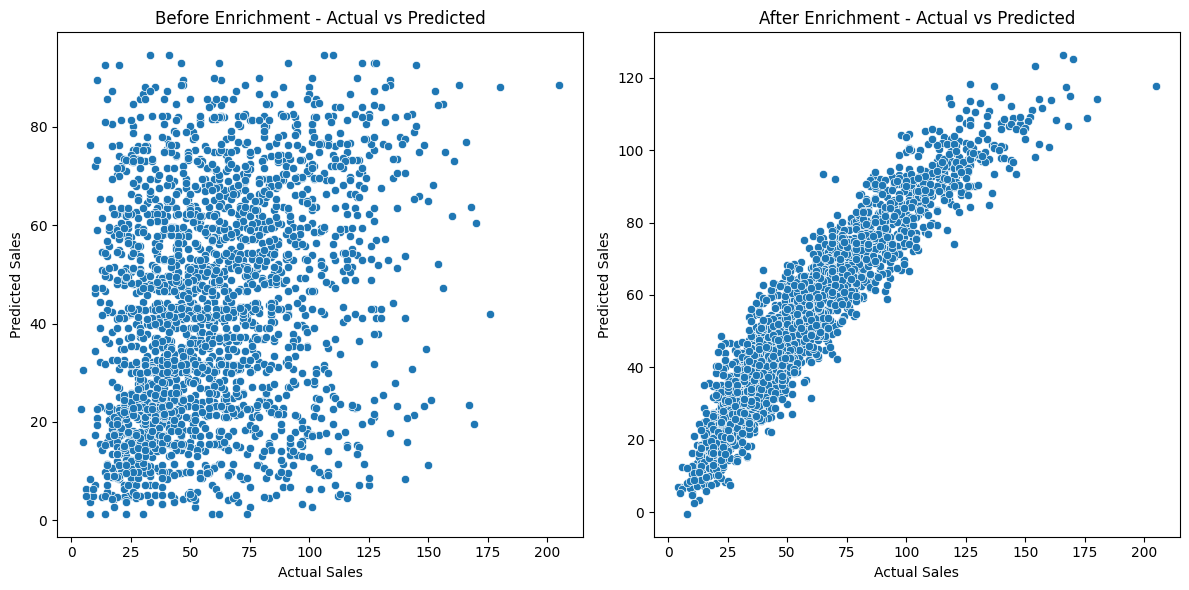

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Before Enrichment - Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_target.values, y=preds)
plt.title('Before Enrichment - Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

# After Enrichment - Actual vs Predicted
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_target.values, y=enriched_preds)
plt.title('After Enrichment - Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

plt.tight_layout()
plt.show()
